# Checking GPU

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
!nvidia-smi 

Fri Dec 27 15:20:58 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             27W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Importing Libraries

In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import random
import os

from tensorflow.keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, 
                          Dense, Flatten, Dropout)
from keras.optimizers import RMSprop, Adam, SGD
from keras import regularizers
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.applications import ResNet50, InceptionV3  
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns 

# Importing Dataset

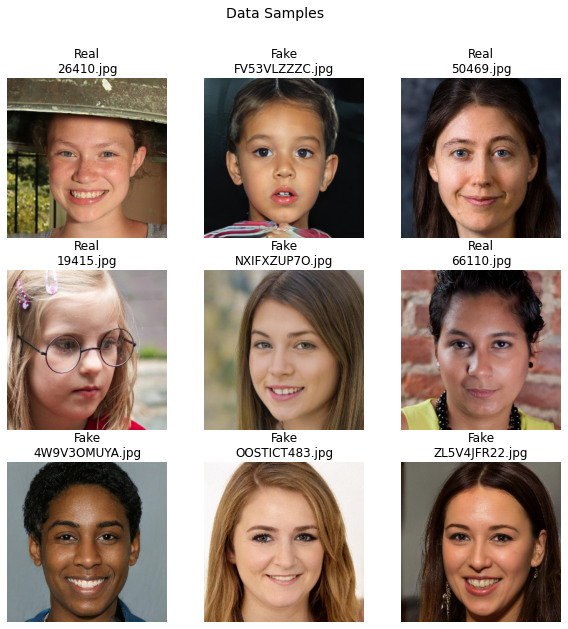

In [4]:
path = '../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

real_dir = os.path.join(path, 'train', 'real')
fake_dir = os.path.join(path, 'train', 'fake')

real_images = [os.path.join(real_dir, img) for img in os.listdir(real_dir)]
fake_images = [os.path.join(fake_dir, img) for img in os.listdir(fake_dir)]

labeled_images = [(img, 'Real') for img in real_images] + [(img, 'Fake') for img in fake_images] 

random.shuffle(labeled_images) 

k = 0
fig, ax = plt.subplots(3, 3, figsize=(10, 10)) 
for j in range(3):
    for i in range(3):
        img_path, label = labeled_images[k]
        img = load_img(img_path)          
        ax[j, i].imshow(img)
        ax[j, i].set_title(f"{label}\n{os.path.basename(img_path)}", fontsize=12)  
        ax[j, i].axis('off')
        k += 1

fig.suptitle('Data Samples', fontsize=14)
plt.show()


# Data Splits

In [5]:
BATCH_SIZE = 64
row, col = 224, 224
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True
                                  )
training_set = train_datagen.flow_from_directory(path + '/train',
                                                 class_mode='binary',
                                                 shuffle=True,
                                                 target_size=(row,col),
                                                 batch_size=BATCH_SIZE
                                                )
val_test_datagen = ImageDataGenerator(rescale=1./255)

validation_set = val_test_datagen.flow_from_directory(path + '/valid',
                                                      class_mode='binary',
                                                      shuffle=True,
                                                      target_size=(row,col),
                                                      batch_size=BATCH_SIZE
                                                     ) 
test_set = val_test_datagen.flow_from_directory(path + '/test',
                                                class_mode='binary',
                                                shuffle=False,
                                                target_size=(row,col),
                                                batch_size=BATCH_SIZE
                                               )
training_set.class_indices

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


{'fake': 0, 'real': 1}

#  Models

##  Denset121

In [10]:
def get_model():
    densenet = DenseNet121(weights='imagenet',
                           include_top=False,
                           input_shape=(224,224,3)
                          )
    model = tf.keras.models.Sequential([densenet,
                                        GlobalAveragePooling2D(),
                                        Dense(512, activation='relu'),
                                        BatchNormalization(),
                                        Dropout(0.3),
                                        Dense(1, activation='sigmoid')
                                      ])
    model.compile(optimizer=Adam(lr=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']
                )

    return model

FakeDetect = get_model()
FakeDetect.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 7,564,865
Trainable params: 7,480,193
Non-t

In [12]:
checkpoint = ModelCheckpoint(filepath='spoffnet.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [13]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

hist = FakeDetect.fit(training_set,
                    validation_data=validation_set,
                    callbacks=callbacks,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=4
                   )

Epoch 1/4
1562/1562 [==============================] - ETA: 0s - loss: 0.1702 - accuracy: 0.9307
Epoch 00001: val_loss improved from inf to 0.28319, saving model to spoffnet.h5
1562/1562 [==============================] - 985s 631ms/step - loss: 0.1702 - accuracy: 0.9307 - val_loss: 0.2832 - val_accuracy: 0.8808
Epoch 2/4
1562/1562 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9730
Epoch 00002: val_loss improved from 0.28319 to 0.12225, saving model to spoffnet.h5
1562/1562 [==============================] - 624s 399ms/step - loss: 0.0723 - accuracy: 0.9730 - val_loss: 0.1223 - val_accuracy: 0.9511
Epoch 3/4
1562/1562 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9786
Epoch 00003: val_loss did not improve from 0.12225
1562/1562 [==============================] - 622s 398ms/step - loss: 0.0575 - accuracy: 0.9786 - val_loss: 2.0673 - val_accuracy: 0.5768
Epoch 4/4
1562/1562 [==============================] - ETA: 0s - loss: 0.0461 - acc

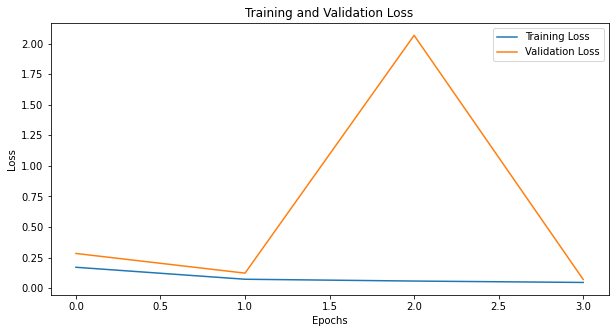

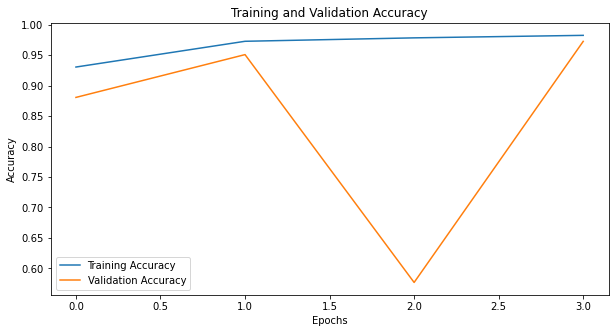

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [16]:
_, accu = FakeDetect.evaluate(test_set)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

313/313 [==============================] - 219s 700ms/step - loss: 0.0670 - accuracy: 0.9740
Final Test Acccuracy = 97.405


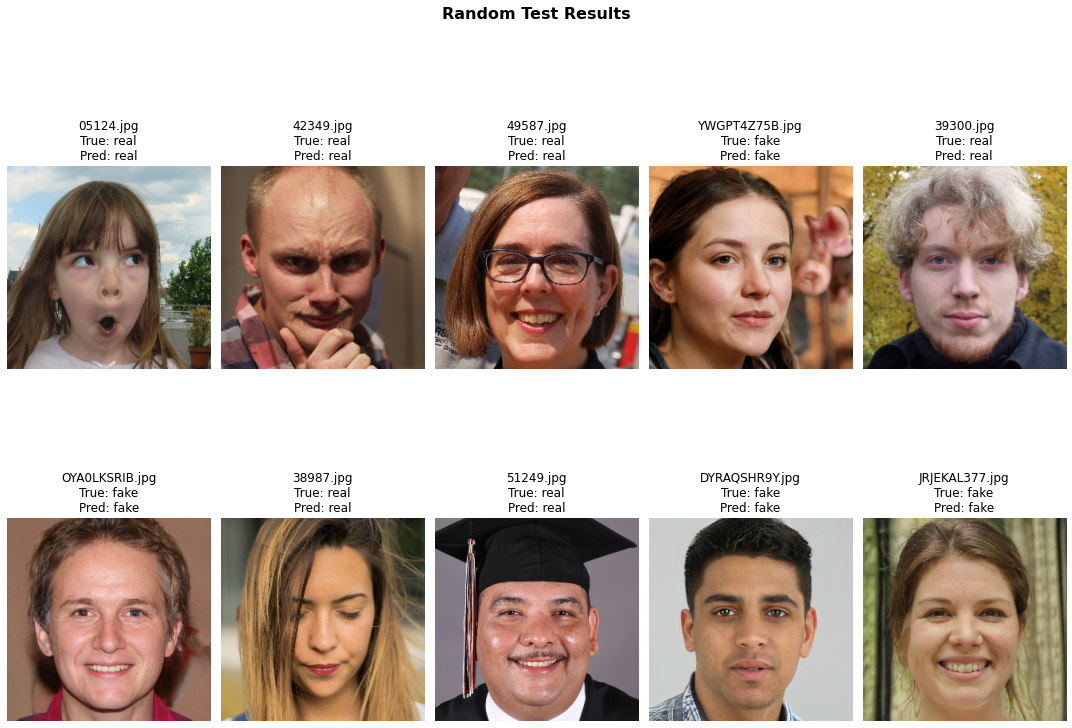

In [59]:
random_indices = random.sample(range(len(test_set.filenames)), 10)  

selected_filepaths = [test_set.filepaths[idx] for idx in random_indices]
selected_labels = [test_set.labels[idx] for idx in random_indices]

selected_images = [img_to_array(load_img(filepath, target_size=(224, 224))) for filepath in selected_filepaths]
selected_images_preprocessed = np.array(selected_images) / 255.0  # Normalize

predicted_probs = FakeDetect.predict(selected_images_preprocessed)
predicted_labels = (predicted_probs >= 0.5).astype(int)

class_indices = {v: k for k, v in training_set.class_indices.items()}
true_label_names = [class_indices[label] for label in selected_labels]
predicted_label_names = [
    class_indices[label[0]] for label in predicted_labels
]

plt.figure(figsize=(15, 12))
plt.suptitle("Random Test Results", fontsize=16, fontweight='bold')

for i, filepath in enumerate(selected_filepaths):
    plt.subplot(2, 5, i + 1)  
    plt.imshow(plt.imread(filepath))  
    plt.axis("off")
    plt.title(
        f"{filepath.split('/')[-1]}\nTrue: {true_label_names[i]}\nPred: {predicted_label_names[i]}",
        fontsize=12,
    )
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to accommodate the title
plt.show()

In [27]:
y_pred = FakeDetect.predict(test_set)
y_pred = (y_pred >= 0.5).astype(int)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm)

target_names = ['fake', 'real']
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=target_names))


Confusion Matrix
[[9595  405]
 [ 114 9886]]
Classification Report
              precision    recall  f1-score   support

        fake       0.99      0.96      0.97     10000
        real       0.96      0.99      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



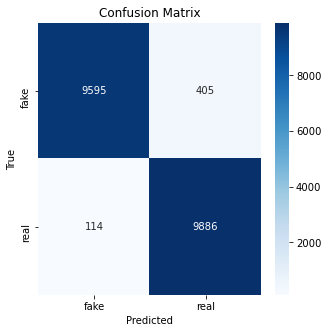

In [28]:
import seaborn as sns
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [29]:
FakeDetect.save('FakeDetect_saved_model', save_format='tf')
print("Model saved in TensorFlow SavedModel format.")

Model saved in TensorFlow SavedModel format.


##  Resnet50

In [12]:
def get_resnet_model():
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = tf.keras.models.Sequential([
        resnet,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(lr=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

ResNetModel = get_resnet_model()
print("ResNet50 Model Summary")
ResNetModel.summary()


ResNet50 Model Summary
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_96 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 24,639,361
Trainable params: 24,585,217
Non-trainable params: 54,144
______________

In [14]:
resnet_checkpoint = ModelCheckpoint(filepath='resnet_model.h5',
                                     save_best_only=True,
                                     verbose=1,
                                     monitor='val_loss')
resnet_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                     factor=0.2,
                                     patience=3,
                                     verbose=1,
                                     min_delta=0.0001)
resnet_csv_logger = CSVLogger('resnet_training.log')

resnet_callbacks = [resnet_checkpoint, resnet_reduce_lr, resnet_csv_logger]

resnet_hist = ResNetModel.fit(training_set,
                              validation_data=validation_set,
                              callbacks=resnet_callbacks,
                              steps_per_epoch=training_set.n // training_set.batch_size,
                              validation_steps=validation_set.n // validation_set.batch_size,
                              epochs=4)

Epoch 1/4
1562/1562 [==============================] - ETA: 0s - loss: 0.2503 - accuracy: 0.8941
Epoch 00001: val_loss improved from inf to 1.14607, saving model to resnet_model.h5
1562/1562 [==============================] - 1122s 718ms/step - loss: 0.2503 - accuracy: 0.8941 - val_loss: 1.1461 - val_accuracy: 0.6424
Epoch 2/4
1562/1562 [==============================] - ETA: 0s - loss: 0.1016 - accuracy: 0.9614
Epoch 00002: val_loss improved from 1.14607 to 0.23050, saving model to resnet_model.h5
1562/1562 [==============================] - 592s 379ms/step - loss: 0.1016 - accuracy: 0.9614 - val_loss: 0.2305 - val_accuracy: 0.9054
Epoch 3/4
1562/1562 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9735
Epoch 00003: val_loss did not improve from 0.23050
1562/1562 [==============================] - 587s 376ms/step - loss: 0.0723 - accuracy: 0.9735 - val_loss: 0.8886 - val_accuracy: 0.6811
Epoch 4/4
1562/1562 [==============================] - ETA: 0s - loss: 0.0

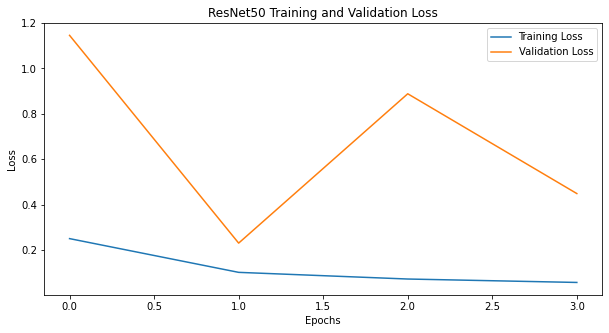

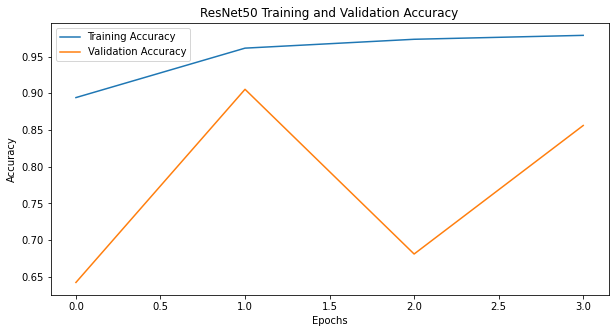

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(resnet_hist.history['loss'], label='Training Loss')
plt.plot(resnet_hist.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(resnet_hist.history['accuracy'], label='Training Accuracy')
plt.plot(resnet_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [37]:
resnet_test_loss, resnet_test_accuracy = ResNetModel.evaluate(test_set)
print(f"ResNet50 Test Accuracy: {resnet_test_accuracy:.3f}")

313/313 [==============================] - 68s 217ms/step - loss: 0.4387 - accuracy: 0.8566
ResNet50 Test Accuracy: 0.857


ResNet50 Confusion Matrix:
[[7150 2850]
 [  17 9983]]
ResNet50 Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      0.71      0.83     10000
        Real       0.78      1.00      0.87     10000

    accuracy                           0.86     20000
   macro avg       0.89      0.86      0.85     20000
weighted avg       0.89      0.86      0.85     20000



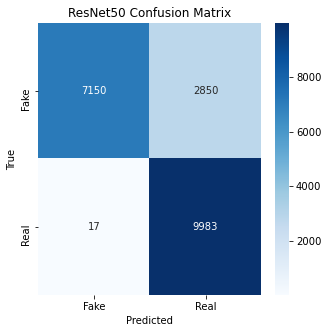

In [31]:
y_pred_resnet = ResNetModel.predict(test_set)
y_pred_resnet = (y_pred_resnet >= 0.5).astype(int)


cm_resnet = confusion_matrix(test_set.classes, y_pred_resnet)
print("ResNet50 Confusion Matrix:")
print(cm_resnet)

print("ResNet50 Classification Report:")
print(classification_report(test_set.classes, y_pred_resnet, target_names=['Fake', 'Real']))

plt.figure(figsize=(5, 5))
sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("ResNet50 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [33]:
ResNetModel.save('ResNetModel_saved', save_format='tf')
print("ResNet50 model saved in TensorFlow SavedModel format.")

ResNet50 model saved in TensorFlow SavedModel format.


##  InceptionV3

In [13]:
def get_inception_model():
    inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = tf.keras.models.Sequential([
        inception,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(lr=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

InceptionModel = get_inception_model()
print("InceptionV3 Model Summary")
InceptionModel.summary()

InceptionV3 Model Summary
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_191 (Bat (None, 512)               2048      
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 22,854,433
Trainable params: 22,818,977
Non-trainable params: 35,456
___________

In [15]:
inception_checkpoint = ModelCheckpoint(filepath='inception_model.h5',
                                        save_best_only=True,
                                        verbose=1,
                                        monitor='val_loss')
inception_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=3,
                                        verbose=1,
                                        min_delta=0.0001)
inception_csv_logger = CSVLogger('inception_training.log')

inception_callbacks = [inception_checkpoint, inception_reduce_lr, inception_csv_logger]
inception_hist = InceptionModel.fit(training_set,
                                    validation_data=validation_set,
                                    callbacks=inception_callbacks,
                                    steps_per_epoch=training_set.n // training_set.batch_size,
                                    validation_steps=validation_set.n // validation_set.batch_size,
                                    epochs=4)

Epoch 1/4
1562/1562 [==============================] - ETA: 0s - loss: 0.1491 - accuracy: 0.9404
Epoch 00001: val_loss improved from inf to 0.08771, saving model to inception_model.h5
1562/1562 [==============================] - 475s 304ms/step - loss: 0.1491 - accuracy: 0.9404 - val_loss: 0.0877 - val_accuracy: 0.9676
Epoch 2/4
1562/1562 [==============================] - ETA: 0s - loss: 0.0557 - accuracy: 0.9800
Epoch 00002: val_loss did not improve from 0.08771
1562/1562 [==============================] - 472s 302ms/step - loss: 0.0557 - accuracy: 0.9800 - val_loss: 2.4487 - val_accuracy: 0.5206
Epoch 3/4
1562/1562 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9857
Epoch 00003: val_loss improved from 0.08771 to 0.03856, saving model to inception_model.h5
1562/1562 [==============================] - 473s 303ms/step - loss: 0.0388 - accuracy: 0.9857 - val_loss: 0.0386 - val_accuracy: 0.9861
Epoch 4/4
1562/1562 [==============================] - ETA: 0s - loss

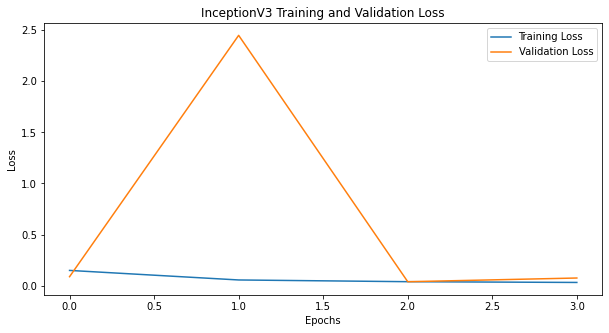

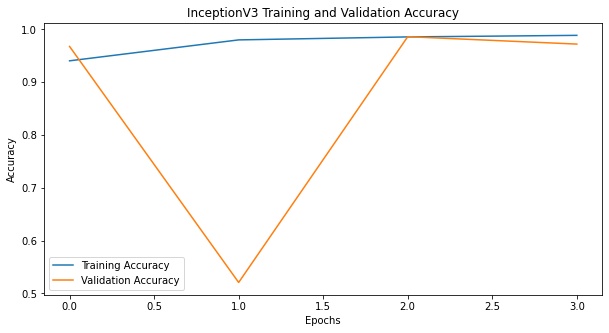

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(inception_hist.history['loss'], label='Training Loss')
plt.plot(inception_hist.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(inception_hist.history['accuracy'], label='Training Accuracy')
plt.plot(inception_hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('InceptionV3 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [36]:
inception_test_loss, inception_test_accuracy = InceptionModel.evaluate(test_set)
print(f"InceptionV3 Test Accuracy: {inception_test_accuracy:.3f}")

313/313 [==============================] - 67s 214ms/step - loss: 0.0730 - accuracy: 0.9724
InceptionV3 Test Accuracy: 0.972


InceptionV3 Confusion Matrix:
[[9529  471]
 [  82 9918]]
InceptionV3 Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.95      0.97     10000
        Real       0.95      0.99      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



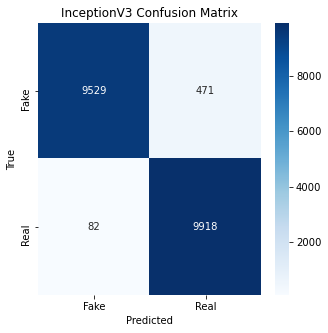

In [32]:
y_pred_inception = InceptionModel.predict(test_set)
y_pred_inception = (y_pred_inception >= 0.5).astype(int)

cm_inception = confusion_matrix(test_set.classes, y_pred_inception)
print("InceptionV3 Confusion Matrix:")
print(cm_inception)

print("InceptionV3 Classification Report:")
print(classification_report(test_set.classes, y_pred_inception, target_names=['Fake', 'Real']))

plt.figure(figsize=(5, 5))
sns.heatmap(cm_inception, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("InceptionV3 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [34]:
InceptionModel.save('InceptionModel_saved', save_format='tf')
print("InceptionV3 model saved in TensorFlow SavedModel format.")

InceptionV3 model saved in TensorFlow SavedModel format.


#  Comparison

In [27]:
dense_test_accuracy =0.9740
dense_test_loss = 0.0670    

In [28]:
model_performance = {
    "Model": ["DenseNet121", "ResNet50", "InceptionV3"],
    "Test Accuracy": [dense_test_accuracy, resnet_test_accuracy, inception_test_accuracy],
    "Test Loss": [dense_test_loss, resnet_test_loss, inception_test_loss]
}

performance_df = pd.DataFrame(model_performance)

print("\nModel Performance Comparison:")
print(performance_df)


Model Performance Comparison:
         Model  Test Accuracy  Test Loss
0  DenseNet121        0.97400   0.067000
1     ResNet50        0.85665   0.438692
2  InceptionV3        0.97235   0.072998


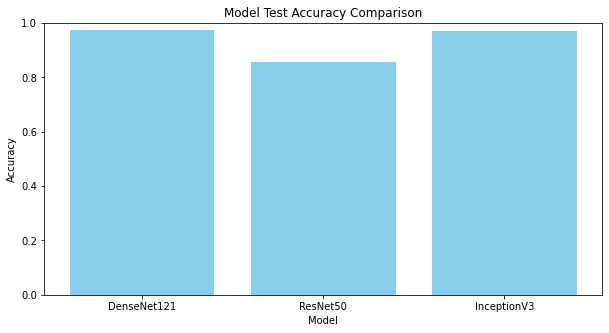

In [29]:
plt.figure(figsize=(10, 5))
plt.bar(performance_df["Model"], performance_df["Test Accuracy"], color='skyblue')
plt.title("Model Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.show()

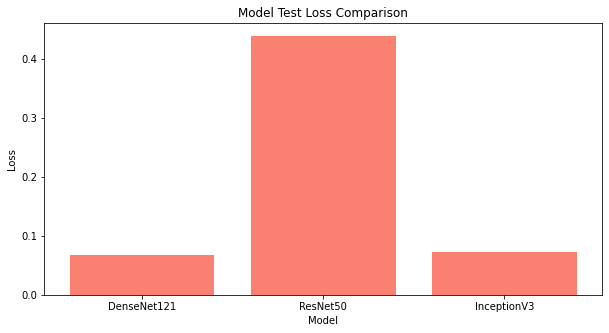

In [30]:
plt.figure(figsize=(10, 5))
plt.bar(performance_df["Model"], performance_df["Test Loss"], color='salmon')
plt.title("Model Test Loss Comparison")
plt.ylabel("Loss")
plt.xlabel("Model")
plt.show()

#  Conclusion
***Densnet121* performed the best as it had the lowest error rate and highest accuracy on the test data**
<br>
****
***Resnet50* did not perform well, might need architectural modifications or further finetuning**
<br>
****
***InceptionV3* Performed really close to Densnet, so if we are want to cut on the compuational cost, this would be a good pick**